In [1]:
import nltk
nltk.download('punkt')
import re
import pymorphy2
import numpy as np
import os
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tag import pos_tag
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.models import load_model
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import json

[nltk_data] Downloading package punkt to /home/tea/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
2023-12-11 17:07:42.844537: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-11 17:07:42.977458: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-11 17:07:43.343713: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-11 17:07:43.345721: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags

In [2]:
alphabet = "абвгдеёжзийклмнопрстуфхцчшщъыьэюя "
maxSentenceLen = 128
sentLimit = 25000

In [3]:
def ohe(sentence, maxSentenceLen):
    encoded = np.zeros((maxSentenceLen, len(alphabet)), dtype=int)
    for i, letter in enumerate(sentence):
        if letter in alphabet:
            encoded[i, alphabet.index(letter)] = 1
    return encoded

In [4]:
morph = pymorphy2.MorphAnalyzer()
directory_path = '../t1/texts'

print('Reading files')

texts = []

files = [file for file in os.listdir(directory_path) if file.endswith(".txt")]

for file in files:
    filePath = os.path.join(directory_path, file)
    with open(filePath, 'r', encoding='utf-8') as file:
        text = file.read()
        texts.append(text)

bigText= ' '.join(texts)

sentences = sent_tokenize(bigText)

print('Cleaning!')

sentences = sentences[:sentLimit]

cleanedSentences = [re.sub(r'[^а-яё\s]', '', sentence.replace('\n', ' ').lower()) for sentence in sentences]
cleanedSentences = [re.sub(r'\s+', ' ', sentence) for sentence in cleanedSentences]
cleanedSentences = [sentence for sentence in cleanedSentences if len(sentence) >= 2]
cleanedSentences = [sentence[:maxSentenceLen-1].rstrip() + " " for sentence in cleanedSentences]

print('Marking sentences')

data = []
labels = []

for sentence in cleanedSentences:
    words = word_tokenize(sentence)

    sentence = []
    sentenceTags = []

    for word in words:
      sentence.append(word)
      sentenceTags.append(morph.lat2cyr(morph.parse(word)[0].tag).split(',')[0])

    data.append(sentence)
    labels.append(sentenceTags)

print("Data:", data[:3])
print("Labels:", labels[:3])


Reading files
Cleaning!
Marking sentences
Data: [['преступление', 'и', 'наказание', 'роман', 'в', 'шести', 'частях', 'с', 'эпилогом', 'часть', 'первая', 'в', 'начале', 'июля', 'в', 'чрезвычайно', 'жаркое', 'время', 'под', 'вечер', 'один', 'м'], ['он', 'благополучно', 'избегнул', 'встречи', 'с', 'своею', 'хозяйкой', 'на', 'лестнице'], ['каморка', 'его', 'приходилась', 'под', 'самою', 'кровлей', 'высокого', 'пятиэтажного', 'дома', 'и', 'походила', 'более', 'на', 'шкаф', 'чем', 'на', 'квартиру']]
Labels: [['СУЩ', 'СОЮЗ', 'СУЩ', 'СУЩ', 'ПР', 'ЧИСЛ рд', 'СУЩ', 'ПР', 'СУЩ', 'СУЩ', 'ПРИЛ', 'ПР', 'СУЩ', 'СУЩ', 'ПР', 'Н', 'СУЩ', 'СУЩ', 'ПР', 'СУЩ', 'ПРИЛ', 'СУЩ'], ['МС', 'Н', 'ГЛ', 'СУЩ', 'ПР', 'ПРИЛ', 'СУЩ', 'ПР', 'СУЩ'], ['СУЩ', 'МС', 'ГЛ', 'ПР', 'ПРИЛ', 'СУЩ', 'ПРИЛ', 'ПРИЛ мр', 'СУЩ', 'СОЮЗ', 'ГЛ', 'Н', 'ПР', 'СУЩ', 'СОЮЗ', 'ПР', 'СУЩ']]


In [5]:
print('Encoding')

dataEncoded = []

for sentence in cleanedSentences:
    sentence_encoded = ohe(sentence, maxSentenceLen)
    dataEncoded.append(sentence_encoded)

dataEncoded = np.array(dataEncoded)

np.set_printoptions(threshold=np.inf)

unique_labels = set(label for sentence_labels in labels for label in sentence_labels)

tags = list(unique_labels)
print(tags)

y = np.zeros((len(dataEncoded), dataEncoded.shape[1], len(tags)))

whitespace=ohe(' ', maxSentenceLen)[0, :]

k=0
indexLabel = tags.index(labels[0][k])
for i in range(dataEncoded.shape[0]):
    k=0
    for j in range(dataEncoded.shape[1]):
        if np.array_equal(dataEncoded[i, j, :], whitespace):
            y[i, j, :] = to_categorical(indexLabel, num_classes=len(tags))
            k += 1
            if k >= len(labels[i]):
                k = 0
            indexLabel = tags.index(labels[i][k])

print('Shapes', dataEncoded.shape, y.shape)


with open('tags.txt', 'w') as filehandle:
    json.dump(tags, filehandle)

Encoding
['ЧИСЛ жр', 'ЧИСЛ им', 'ПРИЛ', 'НЕИЗВ', 'ЧИСЛ пр', 'ПР аббр', 'СОЮЗ искаж', 'ЧИСЛ', 'ЧИСЛ дт', 'ПРИЛ жр', 'ПР в_предл', 'ДЕЕПР', 'ЧИСЛ вн', 'Н', 'ЧИСЛ тв', 'ПРИЛ неод', 'ЧИСЛ од', 'КР_ПРИЛ жр', 'МС', 'КР_ПРИЛ мн', 'ЧАСТ', 'ЧИСЛ мр', 'ПРИЛ од', 'Н искаж', 'КОМП', 'КР_ПРИЛ', 'МЕЖД', 'ЧИСЛ рд', 'ПРЕДК', 'МС мн', 'ГЛ', 'ПРИЛ мн', 'КР_ПРИЧ', 'ИНФ', 'КР_ПРИЛ мр', 'МС ед', 'Н разг', 'Н аббр', 'КР_ПРИЛ ср', 'СОЮЗ', 'ПР', 'ЧИСЛ неод', 'КОМП сравн2', 'КОМП *ей', 'СУЩ', 'ПРИЧ', 'ПРИЛ ср', 'ПРИЛ мр']
Shapes (24228, 128, 34) (24228, 128, 48)


In [6]:
print('Splitting data')
split = .2
size = len(dataEncoded)

a = size - round(size*split)

xTrain = dataEncoded[:a]
xTest = dataEncoded[a:]

yTrain = y[:a]
yTest = y[a:]

print('Train shapes', xTrain.shape, yTrain.shape)
print('Test shapes', xTest.shape, yTest.shape)

Splitting data
Train shapes (19382, 128, 34) (19382, 128, 48)
Test shapes (4846, 128, 34) (4846, 128, 48)


In [22]:
print('Creating Model')
model1 = Sequential()
model1.add(GRU(maxSentenceLen, input_shape=dataEncoded[0].shape, return_sequences=True))
model1.add(Dense(34, activation='relu'))
model1.add(Dense(len(tags), activation='relu'))

model1.summary()

print('Fitting model')
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model1.fit(xTrain, yTrain, epochs=4, batch_size=64)
model1.save('mymodel')

Creating Model
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 128, 128)          62976     
                                                                 
 dense_2 (Dense)             (None, 128, 34)           4386      
                                                                 
 dense_3 (Dense)             (None, 128, 48)           1680      
                                                                 
Total params: 69042 (269.70 KB)
Trainable params: 69042 (269.70 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Fitting model
Epoch 1/4
303/303 [==============================] - 28s 88ms/step - loss: 0.0080 - accuracy: 0.6663
Epoch 2/4
303/303 [==============================] - 26s 87ms/step - loss: 0.0067 - accuracy: 0.8900
Epoch 3/4
303/303 [==============================

INFO:tensorflow:Assets written to: mymodel/assets


Testing model
152/152 [==============================] - 3s 17ms/step


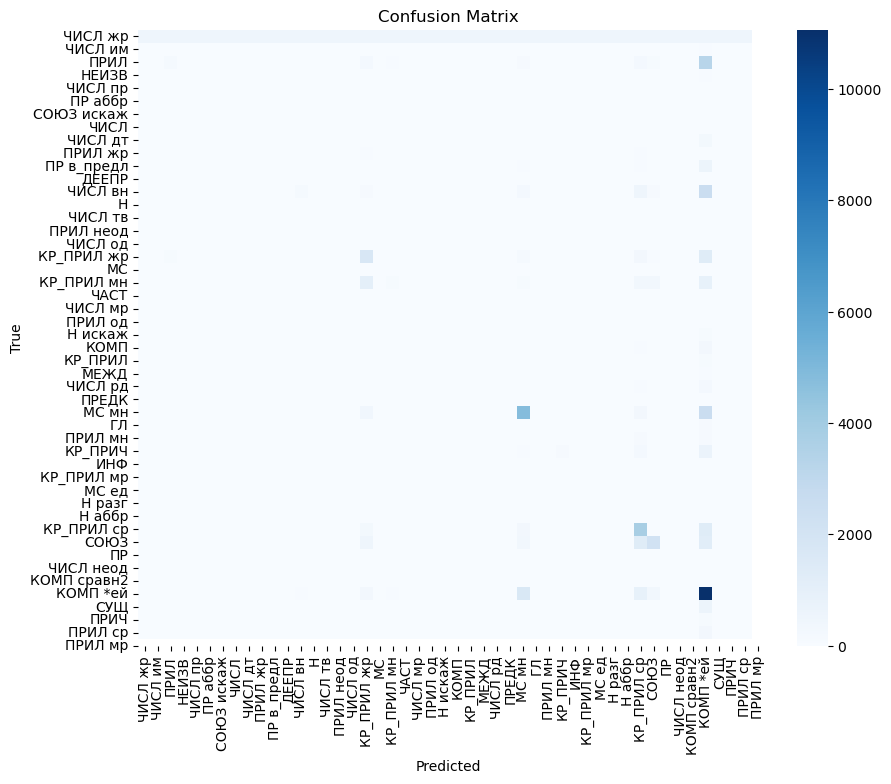

In [23]:
print('Testing model')
yPred = model1.predict(xTest)
yPred = np.argmax(yPred, axis=2)
cm = confusion_matrix(np.argmax(yTest, axis=2).flatten(), yPred.flatten())

cm[cm.argmax()] = cm.max()/100

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=tags, yticklabels=tags)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [24]:
def predictTags(model, sentence, maxSentenceLen):
    sentenceEncoded = ohe(sentence, maxSentenceLen)
    sentenceEncoded = np.expand_dims(sentenceEncoded, axis=0)
    prediction = model.predict(sentenceEncoded)
    predictedTags = np.argmax(prediction, axis=2)[0]
    predictedTags = predictedTags[predictedTags != 0]

    return [tags[index] for index in predictedTags]

In [25]:
with open('tags.txt') as filehandle:
    tags = json.load(filehandle)

In [30]:
morph = pymorphy2.MorphAnalyzer(lang='ru')
mymodel = load_model('mymodel')

sentence = re.sub(r'[^а-яё\s]', '', input("Введите предложение: ").replace('\n', ' ').lower())
sentence = re.sub(r'\s+', ' ', sentence)
sentence = sentence[:maxSentenceLen-1].rstrip() + " "
maxSentenceLen = maxSentenceLen


predictedTags = predictTags(mymodel, sentence, maxSentenceLen)

words = word_tokenize(sentence)
for word, PoS in zip(words, predictedTags):
    print(f"{word} : {PoS}")

Введите предложение:  косил косой косой косой


1/1 [==============================] - 0s 162ms/step
косил : ГЛ
косой : СУЩ
косой : СУЩ
косой : СУЩ
